# Project: Data Wrangling by J.T. Robinson

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gathering data</a></li>
<li><a href="#assess">Assessing data</a></li>
<li><a href="#clean">Cleaning data</a></li>
    <ul>
        <li><a href="#quality">Quality</a></li>
        <li><a href="#tidy">Tidiness</a></li>
    </ul>
<li><a href="#analysis">Storing, Analyzing, and Visualizing Data</a></li>
    <ul>
        <li><a href="#insight1">Insight 1</a></li>
        <li><a href="#insight2">Insight 2</a></li>
        <li><a href="#insight3">Insight 3</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

In this data wrangling project I will gather, assess and clean twitter posts from Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. This project will download 5000+ of their tweets as they stood on August 1, 2017

In [1]:
# Import statements for packages used in project
import numpy as np
import pandas as pd
import json
import requests
import tweepy
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='gather'></a>
## Gathering data

In [2]:
# Read the twitter archive from local storage. Download the image predictions programatically
archive = pd.read_csv('twitter-archive-enhanced.csv')
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)
prediction = pd.read_csv('image-predictions.tsv', sep='\t')

In [3]:
# View the info of the archive DataFrame
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
# View the info of the prediction DataFrame
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [5]:
# Configure Twitter API authentication
consumer_key = 'CONSUMER_KEY'
consumer_secret = 'CONSUMER_SECRET'
access_token = 'ACEESS_TOKEN'
access_secret = 'ACCESS_SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# Read tweets via Twitter API
tweets = []

for tweet in archive['tweet_id']:
    try:
        tweets.append(api.get_status(tweet))
    except tweepy.TweepError as e:
        print('Unable to load data for tweet id:', tweet, 'Reason:', e.args[0][0]['message'])

Unable to load data for tweet id: 888202515573088257 Reason: No status found with that ID.
Unable to load data for tweet id: 873697596434513921 Reason: No status found with that ID.
Unable to load data for tweet id: 872668790621863937 Reason: No status found with that ID.
Unable to load data for tweet id: 869988702071779329 Reason: No status found with that ID.
Unable to load data for tweet id: 866816280283807744 Reason: No status found with that ID.
Unable to load data for tweet id: 861769973181624320 Reason: No status found with that ID.
Unable to load data for tweet id: 845459076796616705 Reason: No status found with that ID.
Unable to load data for tweet id: 842892208864923648 Reason: No status found with that ID.
Unable to load data for tweet id: 837012587749474308 Reason: No status found with that ID.
Rate limit reached. Sleeping for: 683
Unable to load data for tweet id: 827228250799742977 Reason: No status found with that ID.
Unable to load data for tweet id: 812747805718642688

In [7]:
# Display the number of tweets downloaded
print('Number of tweets successfully downloaded: ', len(tweets))

Number of tweets successfully downloaded:  2340


In [8]:
# Store the tweet JSON data in a list and save the list to tweet_json.txt
# https://stackoverflow.com/questions/47612822/how-to-create-pandas-dataframe-from-twitter-search-api
tweet_json = []
for tweet in tweets:
    tweet_json.append(tweet._json)

with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(tweet_json, indent=4))

In [9]:
# Read the tweet_json.txt data into a Pandas DataFrame
# https://stackoverflow.com/questions/47612822/how-to-create-pandas-dataframe-from-twitter-search-api

tweet_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    data_json = json.load(json_file)
    for each_tweet in data_json:
        tweet_id = each_tweet['id']
        whole_tweet = each_tweet['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_tweet['favorite_count']
        retweet_count = each_tweet['retweet_count']
        created_at = each_tweet['created_at']
        whole_source = each_tweet['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_tweet['retweeted_status'] = each_tweet.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        tweet_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'url': url,
                             'created_at': created_at,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(tweet_list, columns = ['tweet_id', 'favorite_count', 
                                                       'retweet_count', 'created_at',
                                                       'source', 'retweeted_status', 'url'])

In [10]:
# View the info of the tweet_json DataFrame
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 7 columns):
tweet_id            2340 non-null object
favorite_count      2340 non-null int64
retweet_count       2340 non-null int64
created_at          2340 non-null object
source              2340 non-null object
retweeted_status    2340 non-null object
url                 2340 non-null object
dtypes: int64(2), object(5)
memory usage: 128.0+ KB


<a id='assess'></a>
## Assessing data

In [11]:
# Visual assessment of the archive DataFrame
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [12]:
# Visual assessment of the prediction DataFrame
prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [13]:
# Visual assessment of the tweet_json
tweet_json

,tweet_id,favorite_count,retweet_count,created_at,source,retweeted_status,url
0,892420643555336193,37994,8304,Tue Aug 01 16:23:56 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,32621,6136,Tue Aug 01 00:17:27 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,24550,4061,Mon Jul 31 00:18:03 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,41333,8449,Sun Jul 30 15:58:51 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,39522,9150,Sat Jul 29 16:00:24 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3
5,891087950875897856,19854,3045,Sat Jul 29 00:08:17 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/xx5cilW0Dd
6,890971913173991426,11598,2018,Fri Jul 28 16:27:12 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/MV01Q820LT
7,890729181411237888,64096,18422,Fri Jul 28 00:22:40 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/hrcFOGi12V
8,890609185150312448,27271,4181,Thu Jul 27 16:25:51 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/UkrdQyoYxV
9,890240255349198849,31289,7208,Wed Jul 26 15:59:51 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/l3TSS3o2M0


In [14]:
# Sort the the denominators in the archive table
archive.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
1574     10
1573     10
1572     10
1563     10
1570     10
1569     10
1568     10
1567     10
1566     10
1565     10
1564     10
1577     10
1571     10
0        10
1562     10
1547     10
1548     10
1549     10
1550     10
1551     10
1552     10
1553     10
1554     10
1555     10
1556     10
       ... 
782      10
781      10
775      10
799      10
780      10
779      10
776      10
777      10
778      10
800      10
784      11
1068     11
1662     11
342      15
1663     16
1165     20
1598     20
1433     40
1202     50
1351     50
1274     50
433      70
1843     80
1254     80
1228     90
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [15]:
# Sort the the numerators in the archive table
archive.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
605        1
1446       1
1869       1
2091       1
2038       1
1940       1
1764       2
2310       2
1761       2
1920       2
2246       2
2237       2
2349       2
2326       2
2079       2
2305       3
1249       3
1898       3
1478       3
1692       3
2202       3
765        3
1928       3
1314       3
2183       3
        ... 
866       14
83        14
291       15
285       15
55        17
1663      20
516       24
1712      26
763       27
1433      44
1274      45
1202      50
1351      60
340       75
695       75
1254      80
433       84
1843      88
1228      99
1635     121
1634     143
1779     144
902      165
290      182
1120     204
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [16]:
# Check for any duplicated tweets in archive table
len(archive[archive.tweet_id.duplicated()])

0

In [17]:
# Sort the names to see any case differences
archive.name.sort_values()

1035            Abby
1021            Abby
938              Ace
1933            Acro
1327           Adele
1934           Aiden
77               Aja
480            Akumi
820               Al
875           Albert
1954          Albert
144            Albus
412            Albus
1115         Aldrick
2046       Alejandro
374        Alexander
1189    Alexanderson
486              Alf
2238           Alfie
661            Alfie
367            Alfie
1616           Alfie
858            Alfie
51              Alfy
201            Alice
1701           Alice
1495           Amber
1334         Ambrose
2078             Amy
2195          Amélie
            ...     
852               my
988              not
335              not
1747      officially
1206             old
993              one
1936             one
924              one
369              one
2326           quite
169            quite
118            quite
193            quite
2030           space
22              such
2345             the
2346         

In [18]:
# Check archive table for any null numerator values
sum(archive.rating_numerator.isnull())

0

In [19]:
# Check archive table for any null denominator values
sum(archive.rating_denominator.isnull())

0

In [20]:
# Check prediction table for any duplicated images
len(prediction[prediction.jpg_url.duplicated()])

66

In [21]:
# Check how many tweets are retweets
tweet_json.retweeted_status.value_counts()

Original tweet       2173
This is a retweet     167
Name: retweeted_status, dtype: int64

### Quality
#### `archive` table
- Some name column entries are not names
- Some denominators are incorrect
- Remove unused dog stage columns
- Remove retweets

#### `prediction` table
- Remove entries that have p1_dog, p2_dog, & p3_dog values set to false. These are not dogs of any kind.
- Remove duplicate jpg_url entries
- Remove unused img_num column

#### `tweet_json` table
- Tweet ID 886267009285017600 does not have a valid URL
- Remove retweets

### Tidiness
- Join archive, predictions and tweet_json tables
- Convert data type of tweet_id in tweet_json table from object to int64

<a id='clean'></a>
## Cleaning data

In [22]:
# Create copies of the original DataFrames
archive_clean = archive.copy()
prediction_clean = prediction.copy()
tweet_json_clean = tweet_json.copy()

<a id='quality'></a>
### Quality

#### `archive`:  Invalid dog names

#### Define
- Remove entries in the name column that are lower case. 

#### Code

In [23]:
# Use a regular expression to find name entries that are uppercase
archive_clean['name'] = archive_clean.name.str.extract('\\b([A-Z]\\S*)\\b')

In [24]:
# Drop any remaining rows that contain NaN in the name column
archive_clean.dropna(subset=['name'], inplace=True)

In [25]:
# Drop any remaining rows that contain None in the name column
archive_clean = archive_clean[archive_clean.name != 'None']

#### Test

In [26]:
archive_clean['name'].value_counts()

Charlie      12
Oliver       11
Lucy         11
Cooper       11
Lola         10
Tucker       10
Penny        10
Bo            9
Winston       9
Sadie         8
Bailey        7
Daisy         7
Buddy         7
Toby          7
Koda          6
Scout         6
Dave          6
Oscar         6
Rusty         6
Milo          6
Jax           6
Jack          6
Leo           6
Bella         6
Stanley       6
Sammy         5
Finn          5
Louis         5
Oakley        5
Bentley       5
             ..
Tove          1
Edgar         1
Jennifur      1
Devón         1
Jackie        1
Darrel        1
Bruiser       1
Trip          1
Willy         1
Emanuel       1
Billl         1
Arlen         1
Torque        1
Ridley        1
Durg          1
Harlso        1
Beebop        1
Millie        1
Kollin        1
Suki          1
Malikai       1
Sobe          1
Cermet        1
Banditt       1
Maks          1
Holly         1
Patch         1
Shnuggles     1
Moofasa       1
Franq         1
Name: name, Length: 931,

#### Define
- Remove ratings with denominators larger than 10

#### Code

In [27]:
# Remove rows with denominators other than 10
archive_clean = archive_clean[~(archive_clean['rating_denominator'] != 10)]  

#### Test

In [28]:
#Verify that denominators larger than 10 have been removed
archive_clean.rating_denominator.value_counts()

10    1499
Name: rating_denominator, dtype: int64

#### Define
- Drop the dog stage columns. Most entries have None

#### Code

In [29]:
archive_clean.drop(archive_clean.columns[-4:], axis=1, inplace=True)

#### Test

In [30]:
# Verify that last 4 columns indicating dog stage have been removed
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 2325
Data columns (total 13 columns):
tweet_id                      1499 non-null int64
in_reply_to_status_id         1 non-null float64
in_reply_to_user_id           1 non-null float64
timestamp                     1499 non-null object
source                        1499 non-null object
text                          1499 non-null object
retweeted_status_id           111 non-null float64
retweeted_status_user_id      111 non-null float64
retweeted_status_timestamp    111 non-null object
expanded_urls                 1499 non-null object
rating_numerator              1499 non-null int64
rating_denominator            1499 non-null int64
name                          1499 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 164.0+ KB


#### Define
- Remove retweets by deleting rows with non-null values in retweeted_status_id column

#### Code

In [31]:
# Remove rows that have values in the retweeted_status_id column
archive_clean = archive_clean[archive_clean['retweeted_status_id'].isnull()]

In [32]:
# Drop empty retweeted_status columns and associated in_reply columns
archive_clean = archive_clean.drop(['retweeted_status_id', 
                                    'retweeted_status_user_id',  
                                    'retweeted_status_timestamp',
                                    'in_reply_to_status_id',
                                    'in_reply_to_user_id'], axis=1)

#### Test

In [33]:
# Verify no values in the retweeted columns
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1388 entries, 0 to 2325
Data columns (total 8 columns):
tweet_id              1388 non-null int64
timestamp             1388 non-null object
source                1388 non-null object
text                  1388 non-null object
expanded_urls         1388 non-null object
rating_numerator      1388 non-null int64
rating_denominator    1388 non-null int64
name                  1388 non-null object
dtypes: int64(3), object(5)
memory usage: 97.6+ KB


#### `prediction`: Remove entries that have False p1_dog, p2_dog, & p3_dog values


#### Define
- Drop rows with entries that have False p1_dog, p2_dog, & p3_dog values

#### Code

In [34]:
# Only keep rows with entries that have p1_dog, p2_dog, & p3_dog values set to True
prediction_clean = prediction_clean[((prediction_clean['p1_dog'] == True) & 
                  (prediction_clean['p2_dog'] == True) & 
                  (prediction_clean['p3_dog'] == True))]

#### Test

In [35]:
# Verify that entries with p1_dog, p2_dog, & p3_dog set to False have been removed
prediction_clean[((prediction_clean['p1_dog'] == False) & 
                  (prediction_clean['p2_dog'] == False) & 
                  (prediction_clean['p3_dog'] == False))]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### Define
- Drops rows with duplicates in the jpg_url column

#### Code

In [36]:
# Drop all rows with duplicate addresses for jpg_url
prediction_clean = prediction_clean.drop_duplicates(subset='jpg_url')

#### Test

In [37]:
# Verify that there are no longer duplicate entries for jpg_url
len(prediction_clean[prediction_clean.jpg_url.duplicated()])

0

#### Define
- Remove img_num column

#### Code

In [38]:
# Drop img_num column
prediction_clean = prediction_clean.drop(['img_num'], axis=1)

#### Test

In [39]:
# Verify img_num column has been dropped
prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 2073
Data columns (total 11 columns):
tweet_id    1206 non-null int64
jpg_url     1206 non-null object
p1          1206 non-null object
p1_conf     1206 non-null float64
p1_dog      1206 non-null bool
p2          1206 non-null object
p2_conf     1206 non-null float64
p2_dog      1206 non-null bool
p3          1206 non-null object
p3_conf     1206 non-null float64
p3_dog      1206 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 88.3+ KB


#### `tweet_json`: Remove retweets

#### Define
- Remove rows with retweets

#### Code

In [40]:
# Keep only original tweets
tweet_json_clean = tweet_json_clean[tweet_json_clean.retweeted_status == 'Original tweet']

#### Test

In [41]:
# Verify that only original tweets remain
tweet_json_clean.retweeted_status.value_counts()

Original tweet    2173
Name: retweeted_status, dtype: int64

<a id='tidy'></a>
### Tidiness

`tweet_json`: Incorrect tweet_id datatype

#### Define
- Convert tweet_id from object to int64 to match archive and prediction data types

#### Code

In [42]:
# Change data type of tweet_id to int64
tweet_json_clean['tweet_id'] = tweet_json_clean.tweet_id.astype('int64')

#### Test

In [43]:
# Verify data type of tweet_id
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2339
Data columns (total 7 columns):
tweet_id            2173 non-null int64
favorite_count      2173 non-null int64
retweet_count       2173 non-null int64
created_at          2173 non-null object
source              2173 non-null object
retweeted_status    2173 non-null object
url                 2173 non-null object
dtypes: int64(3), object(4)
memory usage: 135.8+ KB


#### Define
- Combine the archive, prediction and tweet_json table into a single dataframe

#### Code

In [44]:
# Merge the archive and prediction tables into a single dataframe
combined_archive = pd.merge(archive_clean, prediction_clean, on='tweet_id')

In [45]:
# Merge the tweet_json table into the combined_archive table
combined_archive = pd.merge(combined_archive, tweet_json_clean, on='tweet_id')

#### Test

In [46]:
# Verify the structure of the new combined dataframe
combined_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848 entries, 0 to 847
Data columns (total 24 columns):
tweet_id              848 non-null int64
timestamp             848 non-null object
source_x              848 non-null object
text                  848 non-null object
expanded_urls         848 non-null object
rating_numerator      848 non-null int64
rating_denominator    848 non-null int64
name                  848 non-null object
jpg_url               848 non-null object
p1                    848 non-null object
p1_conf               848 non-null float64
p1_dog                848 non-null bool
p2                    848 non-null object
p2_conf               848 non-null float64
p2_dog                848 non-null bool
p3                    848 non-null object
p3_conf               848 non-null float64
p3_dog                848 non-null bool
favorite_count        848 non-null int64
retweet_count         848 non-null int64
created_at            848 non-null object
source_y             

In [47]:
# Visually assess the combined dataframe for any inconsistencies
combined_archive.head()

,tweet_id,timestamp,source_x,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,p1,...,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,created_at,source_y,retweeted_status,url
0,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,...,True,papillon,0.068957,True,32621,6136,Tue Aug 01 00:17:27 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
1,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,...,True,kelpie,0.031379,True,24550,4061,Mon Jul 31 00:18:03 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
2,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,...,True,German_short-haired_pointer,0.175219,True,39522,9150,Sat Jul 29 16:00:24 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3
3,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,...,True,Chesapeake_Bay_retriever,0.118184,True,27271,4181,Thu Jul 27 16:25:51 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/UkrdQyoYxV
4,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,...,True,Chihuahua,0.029248,True,31289,7208,Wed Jul 26 15:59:51 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/l3TSS3o2M0


<a id='analysis'></a>
### Storing, Analyzing, and Visualizing Data

In [48]:
# Store the combined_archive DataFrame in a CSV file
combined_archive.to_csv('twitter_archive_master.csv', 
                         index=False, encoding = 'utf-8')

<a id='insight1'></a>
#### Insight 1
- The most common dog name is Cooper

In [49]:
# Find the total occurrences of each dog name in the cleaned combined_archive dataframe
combined_archive.name.value_counts()

Cooper        9
Charlie       7
Oliver        7
Sadie         6
Koda          6
Toby          5
Tucker        5
Lucy          5
Leo           5
Bo            5
Winston       5
Finn          4
Gus           4
Dave          4
Reggie        4
Bear          4
Daisy         4
Scooter       4
Larry         4
Stanley       4
Oscar         4
Maggie        4
Sophie        4
Sebastian     3
Wilson        3
Jack          3
Reese         3
Olive         3
Rosie         3
Beau          3
             ..
Kloey         1
Bell          1
Heinrich      1
Christoper    1
Bloo          1
Tater         1
JD            1
Mac           1
Mingus        1
Saydee        1
Maxaroni      1
Shelby        1
Bones         1
Ralphie       1
Thor          1
Sugar         1
Socks         1
Benny         1
Tyrone        1
Fred          1
Rinna         1
Jebberson     1
Crouton       1
Banjo         1
Marq          1
Carper        1
Lance         1
Taz           1
Emma          1
BeBe          1
Name: name, Length: 630,

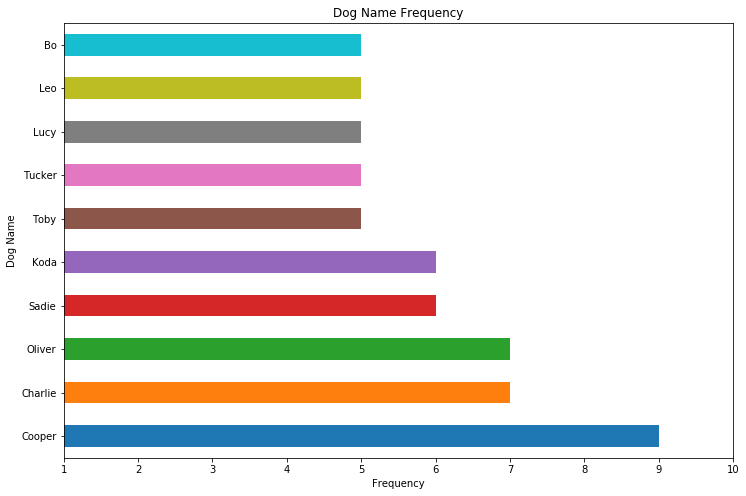

In [50]:
# Plot the top 10 Dog names by frequency
plt.figure(figsize=(12, 8))
dog_names = combined_archive.name.value_counts().nlargest(10).plot(kind = 'barh');
dog_names.set_title('Dog Name Frequency');
dog_names.set_xlabel('Frequency');
dog_names.set_ylabel('Dog Name');
dog_names.set_xlim(1, 10);

<a id='insight2'></a>
#### Insight 2
- The mean rating numerator is 11. Most dogs have a rating numerator between 10 & 12. The clumber has the highest mean rating numerator at 27.

In [51]:
# View summary data for the rating numerator in the cleaned combined_archive dataframe
combined_archive.rating_numerator.describe()

count    848.000000
mean      11.009434
std        1.717994
min        2.000000
25%       10.000000
50%       11.000000
75%       12.000000
max       27.000000
Name: rating_numerator, dtype: float64

In [52]:
# Find the dog breed with the highest numerator
combined_archive.groupby('p1')['rating_numerator'].mean().nlargest(10)

p1
clumber                27.000000
Bedlington_terrier     13.500000
Irish_setter           13.000000
Border_terrier         12.333333
Saluki                 12.333333
Irish_water_spaniel    12.000000
Tibetan_mastiff        12.000000
briard                 12.000000
silky_terrier          12.000000
standard_schnauzer     12.000000
Name: rating_numerator, dtype: float64

<a id='insight3'></a>
#### Insight 3
- The most frequent dog breed first prediction for a given dog is golden retriever follower by labrador retriever in the second and third predictions. The prediction algorithm has a 63% confidence for the first prediction followed by 14% for the second prediction and only 6% for the third prediction.

In [53]:
# Top 10 most frequent p1 dog breed predictions 
combined_archive.p1.value_counts().nlargest(10)

golden_retriever      76
Pembroke              56
Labrador_retriever    50
Chihuahua             38
pug                   26
Pomeranian            20
toy_poodle            20
malamute              19
chow                  18
cocker_spaniel        16
Name: p1, dtype: int64

In [54]:
# Find the mean confidence of the p1 predictions
combined_archive.p1_conf.mean()

0.6299189900943396

In [55]:
# Top 10 most frequent p2 dog breed predictions 
combined_archive.p2.value_counts().nlargest(10)

Cardigan              46
Labrador_retriever    46
golden_retriever      40
French_bulldog        21
miniature_poodle      20
collie                20
Chihuahua             19
Pomeranian            19
Eskimo_dog            19
toy_poodle            19
Name: p2, dtype: int64

In [56]:
# Find the mean confidence of the p2 predictions
combined_archive.p2_conf.mean()

0.14119418964457559

In [57]:
# Top 10 most frequent p3 dog breed predictions 
combined_archive.p3.value_counts().nlargest(10)

Labrador_retriever          45
Chihuahua                   37
kelpie                      24
Pekinese                    20
golden_retriever            20
beagle                      20
malamute                    19
cocker_spaniel              19
Eskimo_dog                  19
Chesapeake_Bay_retriever    19
Name: p3, dtype: int64

In [58]:
# Find the mean confidence of the p3 predictions
combined_archive.p3_conf.mean()

0.061495931211438655